A/B Testing: Step by Step & Hypothesis Testing

1. Understanding business problem & data
2. Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
3. Look summary stats and plots
4. Apply hypothesis testing and check assumptions
    - Check Normality & Homogeneity
    - Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
5. Evaluate the results
6. Make inferences 
7. Recommend business decision to your customer/director/ceo etc. 

1. PACKAGES

In [1]:
# Base
# -----------------------------------
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Hypothesis Testing
# -----------------------------------
from scipy.stats import shapiro
import scipy.stats as stats

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

2. DATA

In [2]:
ab = pd.read_csv("C:\\Users\\alexr\\Desktop\\   \\Work\\Data Science\\In Use\\0. Archive\\Data\\AB_Testing - Cookie Cats.csv")

In [18]:
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


3. SUMMARY STATS

In [10]:
ab.describe([0.10, 0.25, 0.75, 0.90])[['sum_gamerounds']].T

,count,mean,std,min,10%,25%,50%,75%,90%,max
sum_gamerounds,90189.0000,51.8725,195.0509,0.0000,1.0000,5.0000,16.0000,51.0000,134.0000,49854.0000


In [11]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0000,52.4563,256.7164,49854
gate_40,45489,16.0000,51.2988,103.2944,2640


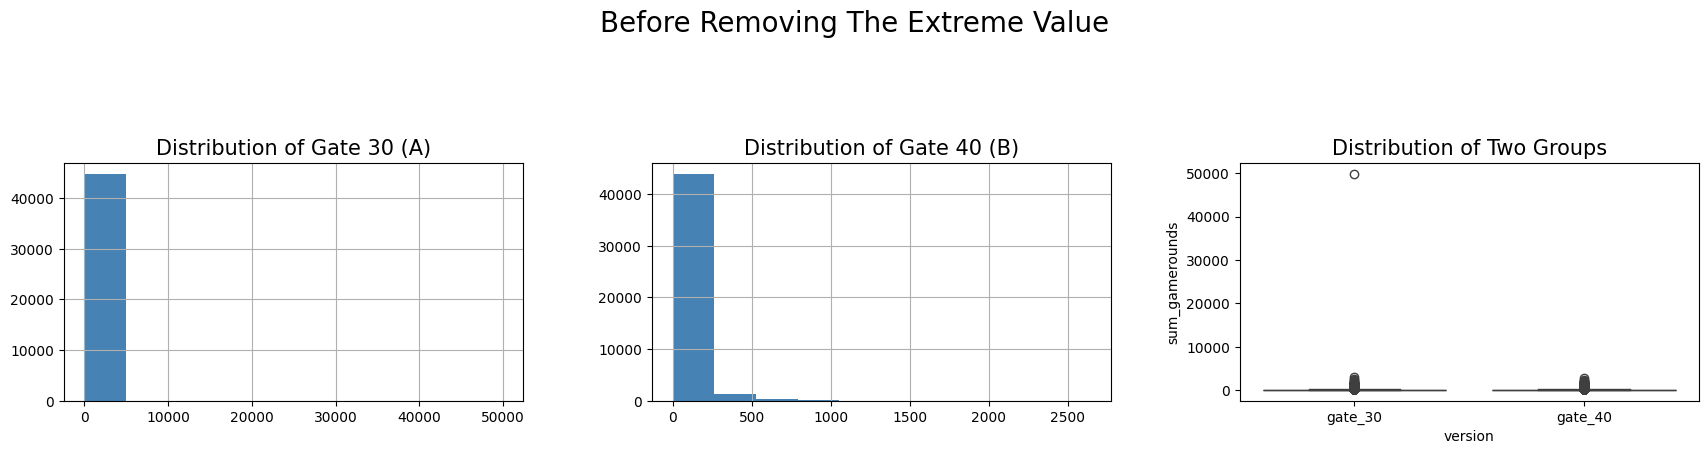

In [12]:
fig, axes = plt.subplots(1, 3, figsize = (18,5))
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[2])

plt.suptitle("Before Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[1].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[2].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

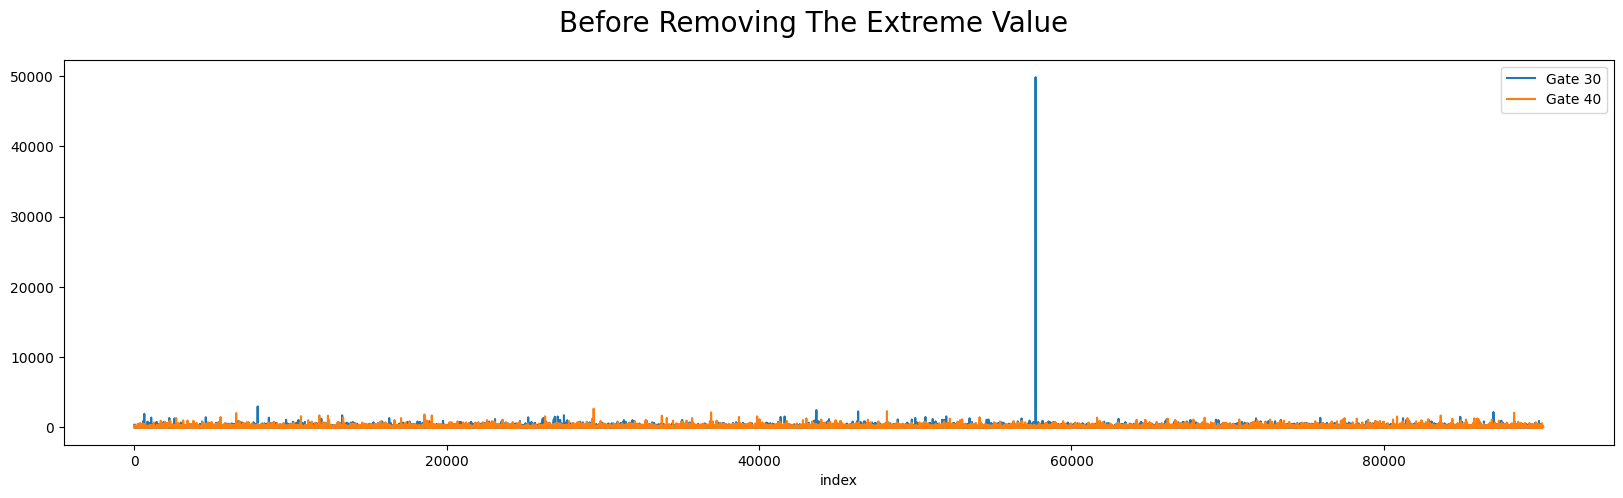

In [13]:
ab[ab.version == "gate_30"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40")
plt.suptitle("Before Removing The Extreme Value", fontsize = 20);

4. OUTLIERS

In [14]:
ab = ab[ab.sum_gamerounds < ab.sum_gamerounds.max()]

# Summary Stats: sum_gamerounds
ab.describe([0.10, 0.25, 0.75, 0.90])[["sum_gamerounds"]].T

,count,mean,std,min,10%,25%,50%,75%,90%,max
sum_gamerounds,90188.0000,51.3203,102.6827,0.0000,1.0000,5.0000,16.0000,51.0000,134.0000,2961.0000


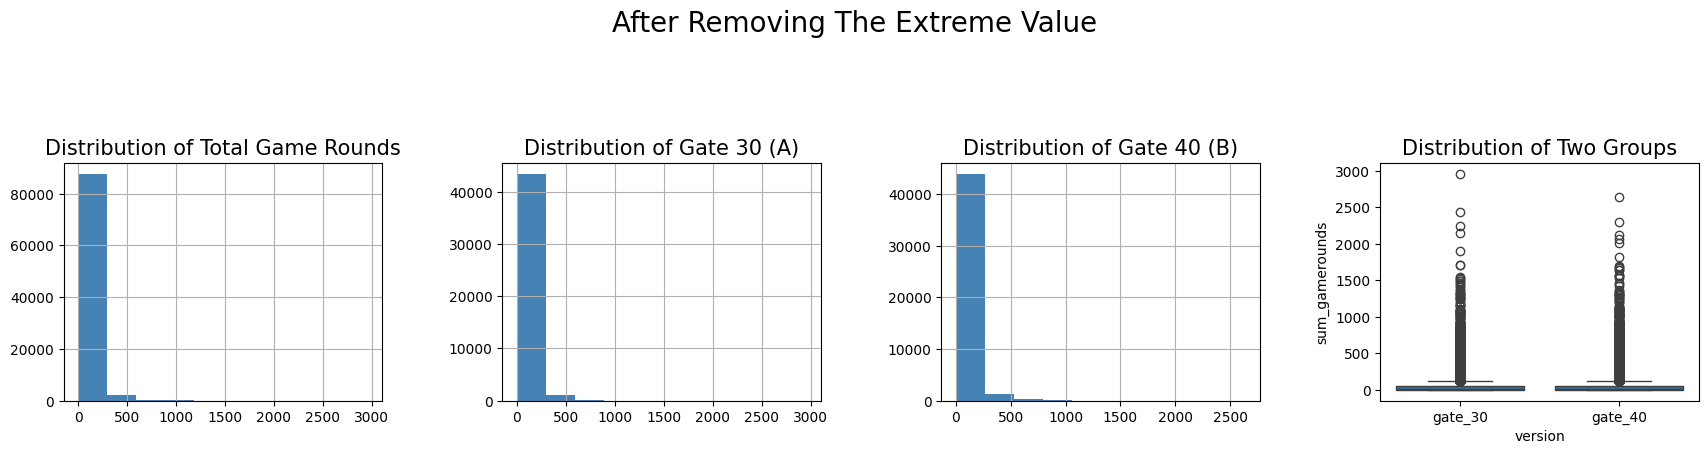

In [15]:
fig, axes = plt.subplots(1, 4, figsize = (18,5))
ab.sum_gamerounds.hist(ax = axes[0], color = "steelblue")
ab[(ab.version == "gate_30")].hist("sum_gamerounds", ax = axes[1], color = "steelblue")
ab[(ab.version == "gate_40")].hist("sum_gamerounds", ax = axes[2], color = "steelblue")
sns.boxplot(x = ab.version, y = ab.sum_gamerounds, ax = axes[3])

plt.suptitle("After Removing The Extreme Value", fontsize = 20)
axes[0].set_title("Distribution of Total Game Rounds", fontsize = 15)
axes[1].set_title("Distribution of Gate 30 (A)", fontsize = 15)
axes[2].set_title("Distribution of Gate 40 (B)", fontsize = 15)
axes[3].set_title("Distribution of Two Groups", fontsize = 15)

plt.tight_layout(pad = 4);

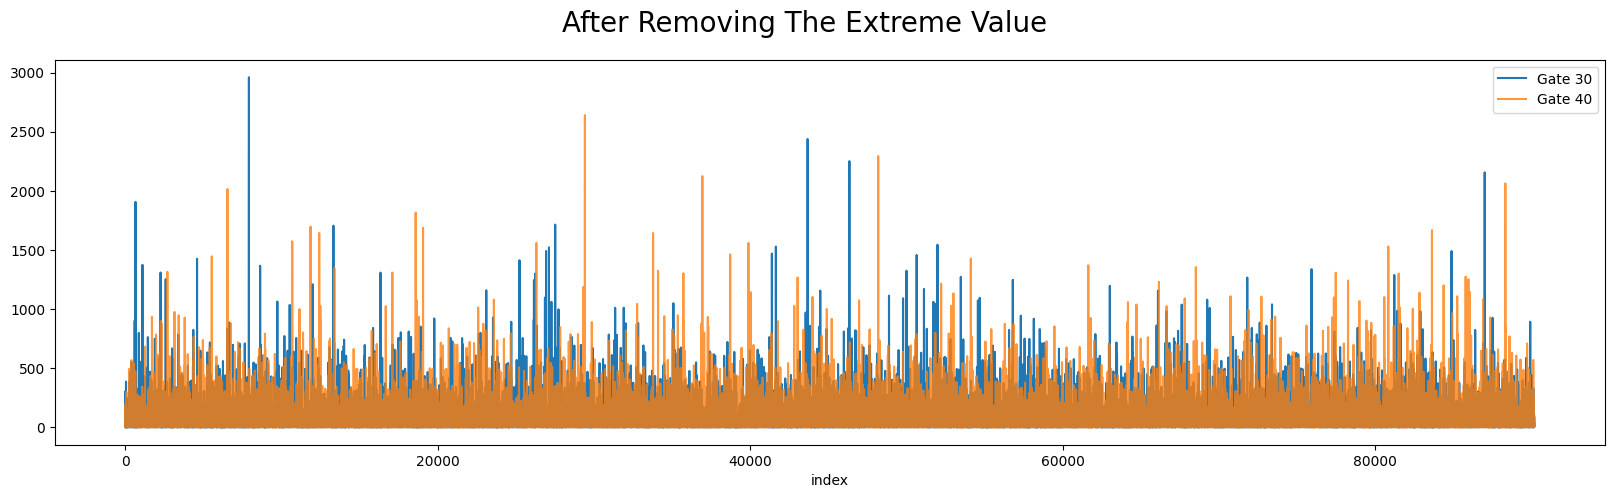

In [16]:
ab[(ab.version == "gate_30")].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 30", figsize = (20,5))
ab[ab.version == "gate_40"].reset_index().set_index("index").sum_gamerounds.plot(legend = True, label = "Gate 40", alpha = 0.8)
plt.suptitle("After Removing The Extreme Value", fontsize = 20);

5. SOME DETAILS

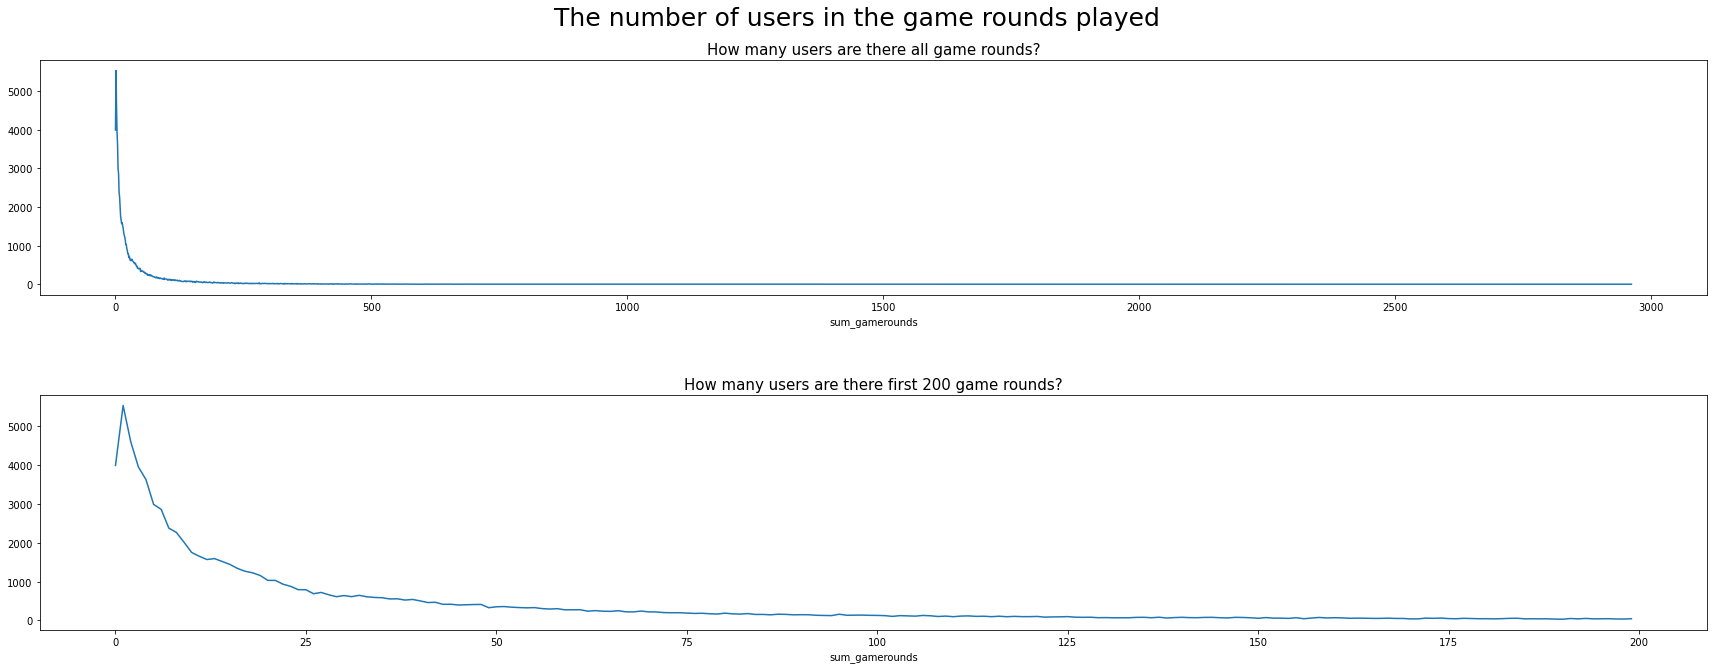

In [10]:
fig, axes = plt.subplots(2, 1, figsize = (25,10))
ab.groupby("sum_gamerounds").userid.count().plot(ax = axes[0])
ab.groupby("sum_gamerounds").userid.count()[:200].plot(ax = axes[1])
plt.suptitle("The number of users in the game rounds played", fontsize = 25)
axes[0].set_title("How many users are there all game rounds?", fontsize = 15)
axes[1].set_title("How many users are there first 200 game rounds?", fontsize = 15)
plt.tight_layout(pad=5);

In [20]:
ab.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [12]:
# How many users reached gate 30 & gate 40 levels?
ab.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

Looking at the summary statistics, the control and Test groups seem similar, but are the two groups statistically significant? We will investigate this statistically.

In [13]:
# A/B Groups & Target Summary Stats
ab.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17,51.3421,102.0576,2961
gate_40,45489,16,51.2988,103.2944,2640


**Retention variables gives us player retention details.**

<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>

Also players tend not to play the game! There are many players who quit the game.

- 55 percent of the players didn't play the game 1 day after insalling
- 81 percent of the players didn't play the game 7 day after insalling

In [14]:
# Retention Problem
pd.DataFrame({"RET1_COUNT": ab["retention_1"].value_counts(),
              "RET7_COUNT": ab["retention_7"].value_counts(),
              "RET1_RATIO": ab["retention_1"].value_counts() / len(ab),
              "RET7_RATIO": ab["retention_7"].value_counts() / len(ab)})

,RET1_COUNT,RET7_COUNT,RET1_RATIO,RET7_RATIO
False,50035,73408,0.5548,0.8139
True,40153,16780,0.4452,0.1861


Looking at the summary statistics of retention variables by version and comparing with sum_gamerounds, there are similarities between groups. However, it will be more helpful to see if there is a statistically significant difference.

In [15]:
ab.groupby(["version", "retention_1"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median    mean      std   max
version retention_1                                      
gate_30 False        24665       6 16.3591  36.5284  1072
        True         20034      48 94.4117 135.0377  2961
gate_40 False        25370       6 16.3404  35.9258  1241
        True         20119      49 95.3812 137.8873  2640

In [16]:
ab.groupby(["version", "retention_7"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version retention_7                                       
gate_30 False        36198      11  25.7965  43.3162   981
        True          8501     105 160.1175 179.3586  2961
gate_40 False        37210      11  25.8564  44.4061  2640
        True          8279     111 165.6498 183.7925  2294

Similar results are seen when the number of users who came and did not come 1 day and 7 days after the game was installing. Approximately 12.000 users among the total users played the game both 1 day and 7 days after installing the game. 14% of the total users include people who will continue the game in the future.

In [17]:
ab["Retention"] = np.where((ab.retention_1 == True) & (ab.retention_7 == True), 1,0)
ab.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median     mean      std   max
version Retention                                       
gate_30 0          38023      12  28.0703  48.0175  1072
        1           6676     127 183.8863 189.6264  2961
gate_40 0          38983      12  28.1034  48.9278  2640
        1           6506     133 190.2824 194.2201  2294

When the retention variables are combined and the two groups are compared, the summary statistics are similar here as well.

In [18]:
ab["NewRetention"] = list(map(lambda x,y: str(x)+"-"+str(y), ab.retention_1, ab.retention_7))
ab.groupby(["version", "NewRetention"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6,11.8197,21.6426,981
1,gate_30,False-True,1825,43,73.1693,93.2223,1072
2,gate_30,True-False,13358,33,49.6945,58.1254,918
3,gate_30,True-True,6676,127,183.8863,189.6264,2961
4,gate_40,False-False,23597,6,11.9133,20.9010,547
5,gate_40,False-True,1773,47,75.2611,94.4780,1241
6,gate_40,True-False,13613,32,50.0255,60.9246,2640
7,gate_40,True-True,6506,133,190.2824,194.2201,2294


6. A/B Testing

In [19]:
# Define A/B groups
ab["version"] = np.where(ab.version == "gate_30", "A", "B")
ab.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [20]:
# A/B Testing Function - Quick Solution
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    
    
    
# Apply A/B Testing
AB_Test(dataframe=ab, group = "version", target = "sum_gamerounds")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.0254,A/B groups are not similar!


7. Conclusion

### Remember business problem!

**As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.**

Firstly, we investigated relationships and structures in the data. There was no missing value problem but was one outlier problem in the data. Summary stats and plots help us to understand the data and problem.

Before A/B Testing, we shared some details about game, players, problems and suggestion to our customer/director/ceo etc.

After applying A/B Testing, the analysis result gives us some important information. Shapiro Testing rejected H0 for Normality assumption. Therefore we needed to apply a Non-parametric test as called Mann Whitney U to compare two groups. As a result, Mann Whitney U Testing rejected H0 hypothesis and we learned A/B groups are not similar!

Briefly, There are statistically significant difference between two groups about moving first gate from level 30 to level 40 for game rounds. 

### Which level has more advantages in terms of player retention?

1-day and 7-day average retention are higher when the gate is at level 30 than when it is at level 40.

In [21]:
ab.groupby("version").retention_1.mean(), ab.groupby("version").retention_7.mean()

(version
 A   0.4482
 B   0.4423
 Name: retention_1, dtype: float64,
 version
 A   0.1902
 B   0.1820
 Name: retention_7, dtype: float64)

The gate should be at level 30 but average retentions look like similar. We need more data for similarity.